In [1]:
import os
import sys
sys.path.append('../src')
from pathlib import Path
from json import dump, load

import numpy as np
from matplotlib import pyplot as plt

from data import load_data, create_sparsity_mask, split_and_scale_data
from models import build_unet_4conv

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')

In [149]:
# Specify experiment:
model_config = 'unet_4conv'
source = 'slp_realworld'

# Reconstruct path to experiment:
path = Path('GitHub/MarcoLandtHayen/reconstruct-sparse-inputs/results/'+model_config+"_"+source)

# Reload parameters for this experiment:
with open(path / 'parameters.json', 'r') as f:
    parameters=load(f)
    
train_val_split = parameters['train_val_split']
sparsity_all = parameters['sparsity_all']
scale_to = parameters['scale_to']
epochs = parameters['epochs']

In [88]:
## Get an overview of train and validation loss, depending on sparsity.
## Note: Start with epoch 0, hence untrained model.

# Loop over array of desired sparsity:
for i in range(len(sparsity_all)):
        
    # Get current sparsity:
    sparsity = sparsity_all[i]
    
    # Reload loss:
    train_loss = np.load(path / 'sparsity_' f'{int(sparsity*100)}'/ 'train_loss.npy')
    val_loss = np.load(path / 'sparsity_' f'{int(sparsity*100)}'/ 'val_loss.npy')
    
    print("Sparsity: ", sparsity)
    print(train_loss)
    print(val_loss,"\n")
    

Sparsity:  0.99
[15.854914 14.771793  9.516197  8.95417 ]
[14.827856 14.397063 11.217179 10.64541 ] 

Sparsity:  0.95
[15.850833  11.943551   8.317999   7.5384655]
[14.826305 13.326635 10.311848  9.546878] 

Sparsity:  0.9
[15.852915  10.193772   7.9803977  6.7749104]
[14.82705  12.067184  9.987195  8.87797 ] 

Sparsity:  0.75
[15.846786   8.16252    6.6573687  6.3477087]
[14.824221  10.103473   8.701934   8.4147215] 

Sparsity:  0.5
[15.846312 15.855321 15.855321 15.855321]
[14.824986 14.828004 14.828004 14.828004] 



### Inspect all models

In [145]:
## Compare predictions and targets, depending on sparsity and training progress (epoch).
## Note: Start with epoch 0, hence untrained model.

# Specify number of samples to be considered:
n_samples = 2

# Initialize storage for train and validation inputs: Dimensions (#sparsities, #samples, lat, lon)
train_input_all = np.zeros((len(sparsity_all), n_samples, train_input.shape[1], train_input.shape[2]))
val_input_all = np.zeros((len(sparsity_all), n_samples, val_input.shape[1], val_input.shape[2]))

# Initialize storage for train and validation targets: Dimensions (#samples, lat, lon)
train_target_all = np.zeros((n_samples, train_input.shape[1], train_input.shape[2]))
val_target_all = np.zeros((n_samples, val_input.shape[1], val_input.shape[2]))

# Initialize storage for train and validation predictions: Dimensions (#sparsities, #epochs + 1, #samples, lat, lon)
train_pred_all = np.zeros((len(sparsity_all), epochs+1, n_samples, train_input.shape[1], train_input.shape[2]))
val_pred_all = np.zeros((len(sparsity_all), epochs+1, n_samples, val_input.shape[1], val_input.shape[2]))

# Loop over array of desired sparsity:
for i in range(len(sparsity_all)):
        
    # Get current sparsity:
    sparsity = sparsity_all[i]
    
    ## Load complete data, reconstruct sparse data and inputs and targets:

    # Load data:
    data = load_data(source=source)

    # Reload sparsity mask:
    sparsity_mask = np.load(path / 'sparsity_' f'{int(sparsity*100)}' / 'sparsity_mask.npy')
    
    # Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
    # Scale or normlalize data according to statistics obtained from only training data.
    train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
        data, 
        sparsity_mask, 
        train_val_split, 
        scale_to
    )
    
    # Store inputs: Omit final dimension of predictions, that only contains the channel (here: 1)
    train_input_all[i,:,:,:] = train_input[:n_samples,:,:,0]
    val_input_all[i,:,:,:] = val_input[:n_samples,:,:,0]
    
    # Store targets: Only once!
    train_target_all[:,:,:] = train_target[:n_samples,:,:]
    val_target_all[:,:,:] = val_target[:n_samples,:,:]
    
    # Loop over number of epochs:
    for j in range(epochs+1):
        
        # Reload desired model:
        model = tf.keras.models.load_model(path / 'sparsity_' f'{int(sparsity*100)}' / f'epoch_{j}')
        
        # Get model predictions on train and validation data (only first 2 samples):
        train_pred = model.predict(train_input[:2])
        val_pred = model.predict(val_input[:2])
        
        # Store predictions: Omit final dimension of predictions, that only contains the channel (here: 1)
        train_pred_all[i,j,:,:,:] = train_pred[:,:,:,0]
        val_pred_all[i,j,:,:,:] = val_pred[:,:,:,0]

In [165]:
## Plot for single TRAINING input sample: Sparse input, target (=complete data) and predictions over the epochs (start with 0, hence untrained model),
## for specific sparsity:

# Select sparsity setting:
i=3

# Pick sample:
k=0

# Check:
print("Sparsity: ", sparsity_all[i])

Sparsity:  0.75


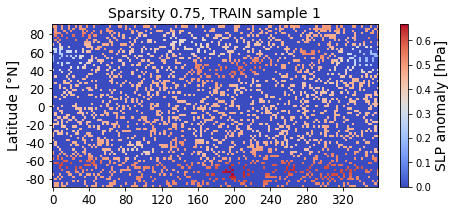

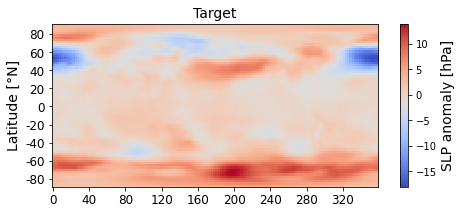

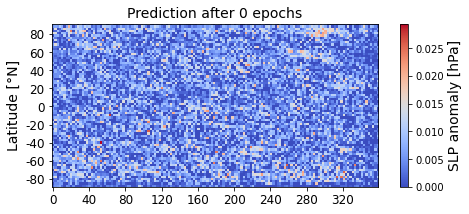

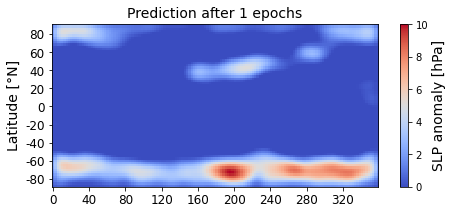

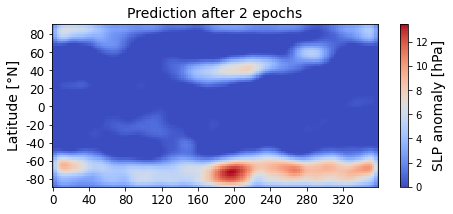

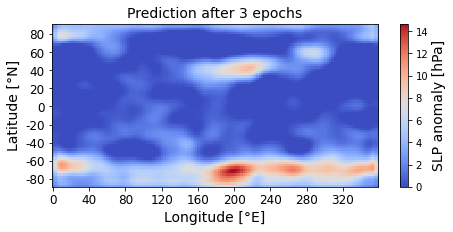

In [169]:
## Plot desired input sample from TRAINING data:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(train_input_all[i,k,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Sparsity '+str(sparsity_all[i])+', TRAIN sample '+str(k+1), fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding target:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(train_target_all[k], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Target', fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding model prediction:

# Loop over epochs:
for j in range(epochs+1):

    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(train_pred_all[i,j,k,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("SLP anomaly [hPa]", fontsize=14)

    plt.title('Prediction after '+str(j)+' epochs', fontsize=14)
    if j == epochs:
        plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()


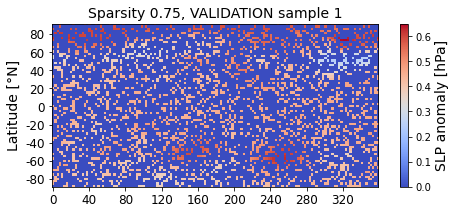

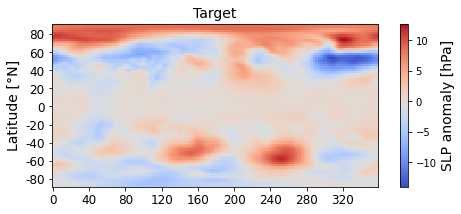

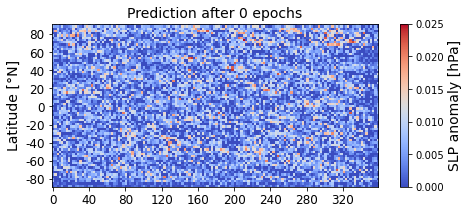

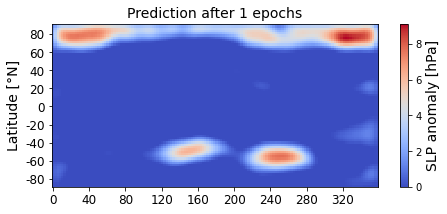

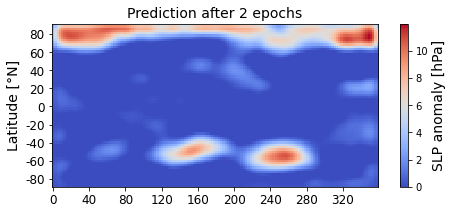

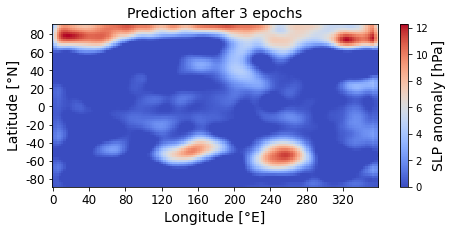

In [170]:
## Plot desired input sample from VALIDATION data:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_input_all[i,k,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Sparsity '+str(sparsity_all[i])+', VALIDATION sample '+str(k+1), fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding target:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_target_all[k], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Target', fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding model prediction:

# Loop over epochs:
for j in range(epochs+1):

    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(val_pred_all[i,j,k,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("SLP anomaly [hPa]", fontsize=14)

    plt.title('Prediction after '+str(j)+' epochs', fontsize=14)
    if j == epochs:
        plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()

In [179]:
## Plot for single TRAINING input sample: Target (=complete data) and predictions after specified epoch for ALL sparsities:

# Specify epoch:
j=3

# Pick sample:
k=1

# Check:
print("Prediction after epoch: ", j)

Prediction after epoch:  3


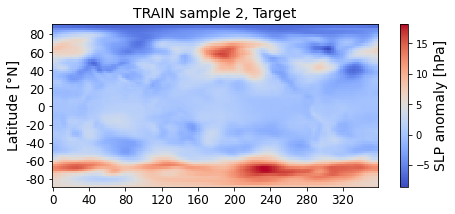

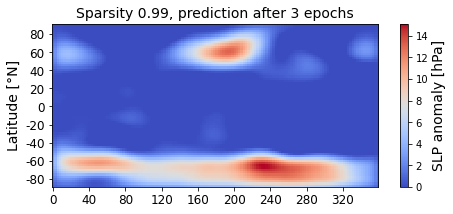

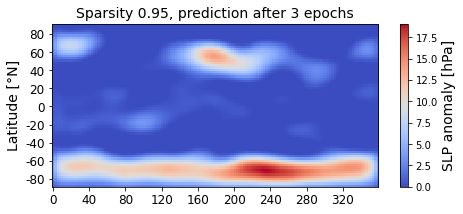

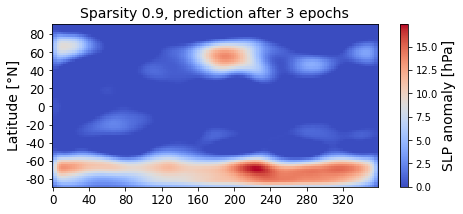

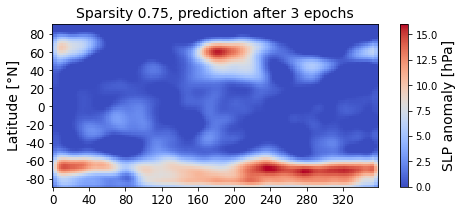

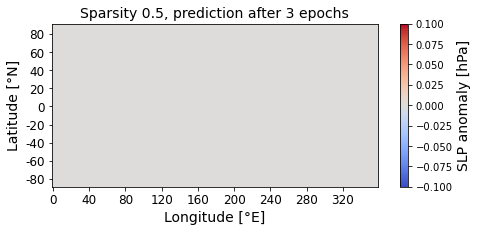

In [183]:
## Plot target from TRAINING data:

fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(train_target_all[k], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('TRAIN sample '+str(k+1)+', Target', fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding model prediction:

# Loop over sparsity settings:
for i in range(len(sparsity_all)):

    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(train_pred_all[i,j,k,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("SLP anomaly [hPa]", fontsize=14)

    plt.title('Sparsity '+str(sparsity_all[i])+', prediction after '+str(j)+' epochs', fontsize=14)
    if i == len(sparsity_all)-1:
        plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()

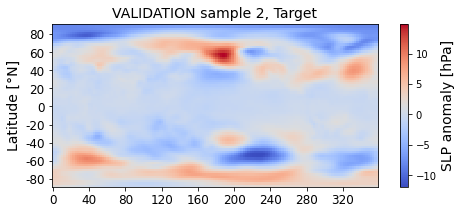

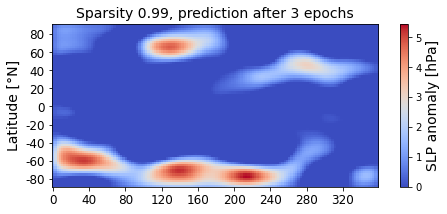

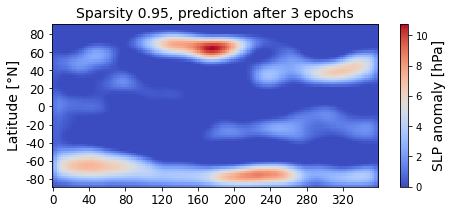

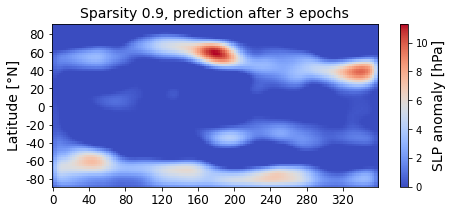

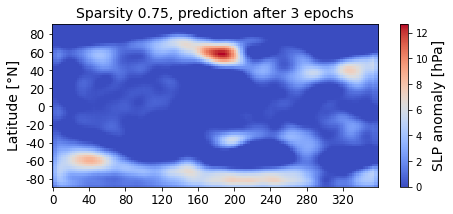

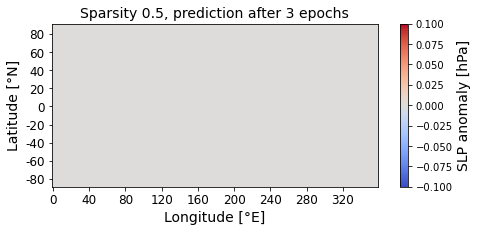

In [184]:
## Plot target from VALIDATION data:

fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_target_all[k], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('VALIDATION sample '+str(k+1)+', Target', fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding model prediction:

# Loop over sparsity settings:
for i in range(len(sparsity_all)):

    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(val_pred_all[i,j,k,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("SLP anomaly [hPa]", fontsize=14)

    plt.title('Sparsity '+str(sparsity_all[i])+', prediction after '+str(j)+' epochs', fontsize=14)
    if i == len(sparsity_all)-1:
        plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()

### Inspect single model

In [89]:
# Set parameters to reload specific model:
sparsity = 0.75
epoch = 3

In [90]:
## Load complete data, reconstruct sparse data and inputs and targets:

# Load data:
data = load_data(source=source)

# Reload sparsity mask:
sparsity_mask = np.load(path / 'sparsity_' f'{int(sparsity*100)}' / 'sparsity_mask.npy')

In [91]:
# Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
# Scale or normlalize data according to statistics obtained from only training data.
train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
    data, 
    sparsity_mask, 
    train_val_split, 
    scale_to
)

In [92]:
# Reload desired model:
model = tf.keras.models.load_model(path / 'sparsity_' f'{int(sparsity*100)}' / f'epoch_{epoch}')

In [93]:
# Get model predictions on train and validation data (only first 10 samples):
train_pred = model.predict(train_input[:10])
val_pred = model.predict(val_input[:10])

In [94]:
# Pick input to visualize sparse input, target (=complete data) and model prediction:
i = 0

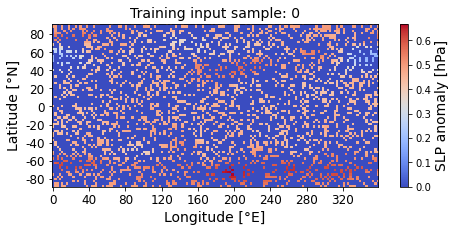

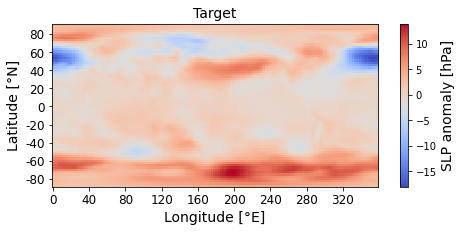

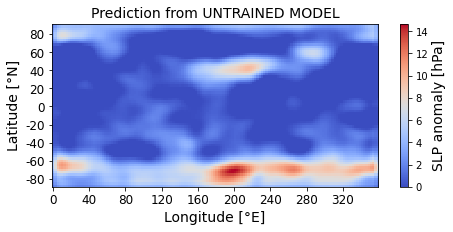

In [95]:
## Plot first input sample from TRAINING data:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(train_input[i], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Training input sample: '+str(i), fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding target:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(train_target[i], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Target', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding model prediction:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(train_pred[i,:,:,0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Prediction from UNTRAINED MODEL', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

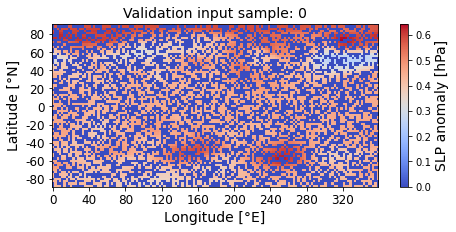

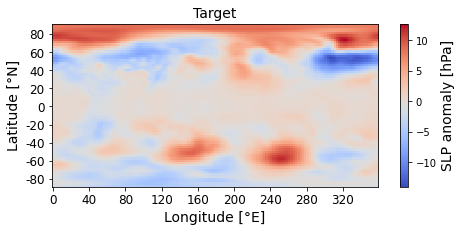

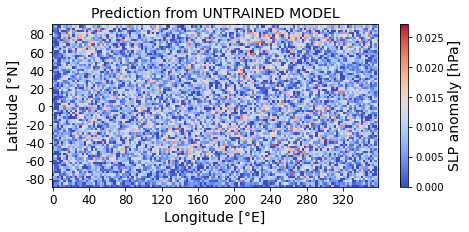

In [82]:
## Plot first input sample from VALIDATION data:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_input[i], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Validation input sample: '+str(i), fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding target:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_target[i], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Target', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding model prediction:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_pred[i,:,:,0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Prediction from UNTRAINED MODEL', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

### Reconstruct full information from incomplete and sparse inputs

#### Background / Motivation

In former experiments, we trained various models on e.g. **complete** sea surface temperature (SST) anomaly fields to detect El Nino Southern Oscillation (ENSO). We used this **simple classification task** to get a deeper understanding of the underlying classification engines by applying **layer-wise relevance propagation (LRP)**. See GitHub repos *ESN_Classification_LRP_ENSO* and *fact_or_artefact*. In other applications, we used sea level pressure (SLP) fields to detect the current Southern Annular Mode (SAM). See local repository *MarDATA_Startprojekt*.

In **real world problems**, we often have more **difficult conditions**:

- We might only have **sparse inputs** from a limited number of valid measurements, e.g. from stations, moorings or argo floats - as a *snapshot*.
- Or from remote sensing, some inputs might be missing to make **inputs incomplete**. This could happen e.g. for SST measurements, since infra-red radiation is scattered or absorbed by clouds.

To reconstruct missing data, statistical methods are often applied. Here, we aim to use deep learning methods instead. In addition to having difficult real world conditions, we like to find out, if our **models grasp at least parts of the underlying physical content**. As an extension, this could be an application of **physics-informed neural networks**: A constraint on SST anomaly fields could e.g. be, that the area-weighted sum of SST anomalies is some constant, due to conservation of energy. And finally, we might have trained a model on specific model data (e.g. FOCI or CESM) and now want to **use it on real-world data** (or different model data), possibly even **with another grid architecture** (transfer learning).

#### Outline

Following [Xiantao et al., 2020](https://www.nature.com/articles/s41598-020-59801-x) Nature article "Deep learning for irregularly and regularly missing data reconstruction", we adopt their U-Net approach for using it on our SST and SLP fields:

- Prepare 2D input fields (latitude-longitude), have only single channel in basic version. We thus start with a **conventional grid** approach.
- Specialty in SST data: Have permanently missing data, since SST is not defined over land masses, in input and target samples, whereas SLP is defined everywhere.
- Randomly sparsify input samples to simulate additional missing data. In any case, **missing data is replaced by ZERO**, at least in a first attempt.
- To **extend the U-Net approach**, we could work with extremly sparse input fields, but add temporal dimension: Stack multiple 2D spatial fields to have a number of time steps (= number of channels in the input data).
- For the sake of simplicity, use a specified number of subsequent months, up to time $t$. Try to reconstruct full spatial information for time $t$ (single output channel).

#### Remarks on Data

Real-world fields already contain reconstructed data, hence we don't know the ground truth. And we probably need many training samples for this U-Net approach. This puts FOCI and CESM data in favor over real-world measurements. We can use each sample multiple times: E.g., for sparsity $95%$, could at least use each sample 20 times, if not 100 times, since we randomly sparsify input samples (--> data augmentation). This gives us 12.000 x 100 = 1.200.000 input samples.

**Note:** Huge amount of input data requires training models on HPC systems. In this first attempt, we therefore work with real-worls SST and SLP fields, to keep computational effort tractable.

#### Outlook

The intuitive approach is to start with 2D fields as arrays, living on a regular grid. Working with sparse but zero-inflated inputs, this might be inefficient, due to most inputs being zero (or NaN). This could be solved by taking a more general approach, that can **handle all kinds of unstructured data**. Just provide a bunch of **quadruples (lat / lon / time / value) as model input**, from an arbitrary **set of grid points**. This also allows switching to another grid architecture, one could then map a quadruple to the closest available grid point.

### Tech preamble

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Load real world SST and SLP data

In [2]:
# Set relative path on local machine (or remote machine):
sst_path = "../data/raw/sst.mnmean.nc"
slp_path = "../data/raw/pres.sfc.mon.mean.nc"

# Load data:
sst_dataset = xr.open_dataset(sst_path)
slp_dataset = xr.open_dataset(slp_path)

In [3]:
# Get summary statistics and source information:
sst_dataset

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2015, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-11-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2021-12-06

In [4]:
# Get summary statistics and source information:
slp_dataset

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 887)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-11-01
Data variables:
    pres     (time, lat, lon) float32 ...
Attributes:
    description:    Data is from NMC initialized reanalysis\n(4x/day).  These...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Thu May  4 18:12:05 2000: ncrcat -d time,0,622 /Datasets/...
    title:          monthly mean pres.sfc from the NCEP Reanalysis
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

### Prepare SLP inputs

- SLP fields don't contain any NaN values. 
- Work with **anomalies**, instead of raw SLP inputs.
- Randomly sparsify samples, according to desired **sparsity**.
- Increase number of samples by a specified **augmentation_factor**.

In [5]:
## Set parameters upfront:
train_val_split = 0.8 # Set rel. amount of samples used for training.
sparsity = 0.9 # Set sparsity of input samples: 0.9 means, that 90% of the values are missing.
augmentation_factor = 10 # Use every sample multiple times, since sparsification is done randomly.
scale_to = 'zero_one' # Choose to scale inputs to [-1,1] ('one_one') or [0,1] ('zero_one'), 
                      # or 'norm' to normalize inputs, or 'no' scaling.

# Start with raw slp fields as lat/lon grids in time, from 1948 to date:
slp_fields = (
    slp_dataset.pres
    .sel(time=slice('1948-01-01', '2021-11-01'))
)

# Compute monthly climatology (here 1980 - 2009) for whole world:
slp_climatology_fields = (
    slp_dataset.pres
    .sel(time=slice('1980-01-01','2009-12-01'))
    .groupby("time.month")
    .mean("time")
)

# Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
slp_anomaly_fields = slp_fields.groupby("time.month") - slp_climatology_fields

# Extract slp anomaly fields' values as iputs:
inputs_slp = np.copy(slp_anomaly_fields.values)

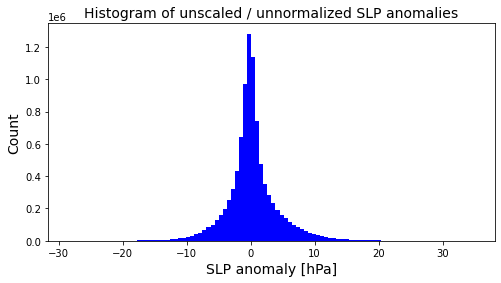

In [6]:
# Plot histogram of SLP anomalies:
nBins = 100
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.hist(inputs_slp.flatten(), nBins, color="blue", label="SLP anomalies")
ax.set_xlabel('SLP anomaly [hPa]', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.title('Histogram of unscaled / unnormalized SLP anomalies', fontsize=14)
plt.show()

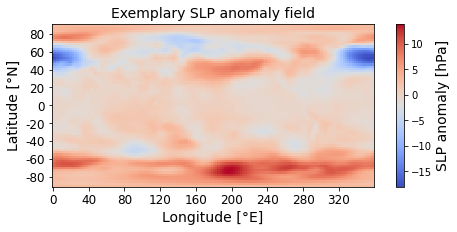

In [7]:
## Plot exemplary sample from SLP anomaly fields:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(inputs_slp[0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Exemplary SLP anomaly field', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

In [8]:
## Split inputs and targets into train and validation data according to train_val_split.

# Get number of train samples:
n_train = int(len(inputs_slp) * train_val_split)

## Optionally scale inputs to [-1,1] or [0,1], according to min/max obtained from only train inputs. 
## Or normalize inputs to have zero mean and unit variance. 

# Remenber min/max used for scaling.
train_min = np.min(inputs_slp[:n_train])
train_max = np.max(inputs_slp[:n_train])

# Remenber mean and std dev used for scaling.
train_mean = np.mean(inputs_slp[:n_train])
train_std = np.std(inputs_slp[:n_train])

# Scale or normalize inputs depending on desired scaling parameter:
if scale_to == 'one_one':
    # Scale inputs to [-1,1]:
    inputs_slp = 2 * (inputs_slp - train_min) / (train_max - train_min) - 1
    
elif scale_to == 'zero_one':
    # Alternatively scale inputs to [0,1]
    inputs_slp = (inputs_slp - train_min) / (train_max - train_min)

elif scale_to == 'norm':
    # Alternatively scale inputs to [0,1]
    inputs_slp = (inputs_slp - train_mean) / train_std

In [9]:
## Randomly sparsify input samples, use each sample multiple times, according to 'augmentation_factor':

# Loop over augmentation_factor:
for i in range(augmentation_factor):
    
    # Get sparsity mask from random uniform distribution in [0,1]:
    random_sparsity_mask = (np.random.uniform(low=0.0, high=1.0, size=inputs_slp.shape)>sparsity).astype(int)

    # Store randomly sparsified input samples and complete targets (for first run need to initialize storage):
    if i == 0:
        inputs_slp_sparse = inputs_slp * random_sparsity_mask     
        targets_slp = inputs_slp
    else:
        inputs_slp_sparse = np.concatenate([inputs_slp_sparse,inputs_slp * random_sparsity_mask])
        targets_slp = np.concatenate([targets_slp,inputs_slp])    

In [10]:
## Remove last row (latidute), to have equal number of steps in latitude (=72). This serves as 'quick-and-dirty'
## solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
inputs_slp_sparse = inputs_slp_sparse[:,:-1,:]
targets_slp = targets_slp[:,:-1,:]

In [11]:
## Split inputs and targets:
train_input = inputs_slp_sparse[:n_train*augmentation_factor]
val_input = inputs_slp_sparse[n_train*augmentation_factor:]
train_target = targets_slp[:n_train*augmentation_factor]
val_target = targets_slp[n_train*augmentation_factor:]

# Add dimension for number of channels, required for Conv2D:
train_input = np.expand_dims(train_input, axis=-1)
val_input = np.expand_dims(val_input, axis=-1)

# Dimensionality check:
print("\nraw inputs shape: ", inputs_slp.shape)
print("augmentation factor: ", augmentation_factor)
print("sparsity: ", sparsity)
print("\ntrain_input shape: ", train_input.shape)
print("val_input shape: ", val_input.shape)
print("train_target shape: ", train_target.shape)
print("val_target shape: ", val_target.shape)
print("\ntrain_input_slp min: ", np.round(train_min,3))
print("train_input_slp max: ", np.round(train_max,3))
print("train_input_slp mean: ", np.round(train_mean,3))
print("train_input_slp std: ", np.round(train_std,3))
print("\nscaled / norm. train_input min: ", np.round(np.min(train_input),3))
print("scaled / norm. train_input max: ", np.round(np.max(train_input),3))
print("scaled / norm. train_input mean: ", np.round(np.mean(train_input),3))
print("scaled / norm. train_input std: ", np.round(np.std(train_input),3))
print("\nscaled / norm. val_input min: ", np.round(np.min(val_input),3))
print("scaled / norm. val_input max: ", np.round(np.max(val_input),3))
print("scaled / norm. val_input mean: ", np.round(np.mean(val_input),3))
print("scaled / norm. val_input std: ", np.round(np.std(val_input),3))


raw inputs shape:  (887, 73, 144)
augmentation factor:  10
sparsity:  0.9

train_input shape:  (7090, 72, 144, 1)
val_input shape:  (1780, 72, 144, 1)
train_target shape:  (7090, 72, 144)
val_target shape:  (1780, 72, 144)

train_input_slp min:  -28.471
train_input_slp max:  34.935
train_input_slp mean:  0.322
train_input_slp std:  3.976

scaled / norm. train_input min:  0.0
scaled / norm. train_input max:  0.998
scaled / norm. train_input mean:  0.045
scaled / norm. train_input std:  0.137

scaled / norm. val_input min:  0.0
scaled / norm. val_input max:  1.0
scaled / norm. val_input mean:  0.045
scaled / norm. val_input std:  0.137


### Set up U-Net

**Note:** Opposed to [Xiantao et al., 2020](https://www.nature.com/articles/s41598-020-59801-x), we omit the fifth convolution, due to dimensionality reasons and the limited number of training samples.

In [37]:
## Set parameters up-front:
CNN_filters = [2,4,8,16] # Number of filters. Originally, [Xintao et al.] used [64,128,256,512]. Training time 16 mins for single epoch!
CNN_kernel_size = 5 # Kernel size
CNN_padding = 'same'
CNN_activation = 'relu'
n_epochs = 1
batch_size = 10
learning_rate = 0.0005
loss_function = 'mse' 

## Define U-Net model:

# Add input layer: Last dim specifies the number of channels, here 1.
input_shape = (train_input.shape[1],train_input.shape[2],1)
inputs = Input(shape=input_shape)

# Add CNN layers:
cnn_1 = Conv2D(filters=CNN_filters[0], kernel_size=CNN_kernel_size, padding=CNN_padding, activation=CNN_activation)(inputs)
cnn_2 = Conv2D(filters=CNN_filters[0], kernel_size=CNN_kernel_size, padding=CNN_padding, activation=CNN_activation)(cnn_1)

# Add max. pooling (2x2):
pool_1 = MaxPool2D(pool_size=(2,2))(cnn_2)

# Add CNN layers:
cnn_3 = Conv2D(filters=CNN_filters[1], kernel_size=CNN_kernel_size, padding=CNN_padding, activation=CNN_activation)(pool_1)
cnn_4 = Conv2D(filters=CNN_filters[1], kernel_size=CNN_kernel_size, padding=CNN_padding, activation=CNN_activation)(cnn_3)

# Add max. pooling (2x2):
pool_2 = MaxPool2D(pool_size=(2,2))(cnn_4)

# Add CNN layers:
cnn_5 = Conv2D(filters=CNN_filters[2], kernel_size=CNN_kernel_size, padding=CNN_padding, activation=CNN_activation)(pool_2)
cnn_6 = Conv2D(filters=CNN_filters[2], kernel_size=CNN_kernel_size, padding=CNN_padding, activation=CNN_activation)(cnn_5)

# Add max. pooling (2x2):
pool_3 = MaxPool2D(pool_size=(2,2))(cnn_6)

# Add CNN layers:
cnn_7 = Conv2D(filters=CNN_filters[3], kernel_size=CNN_kernel_size, padding=CNN_padding, activation=CNN_activation)(pool_3)
cnn_8 = Conv2D(filters=CNN_filters[3], kernel_size=CNN_kernel_size, padding=CNN_padding, activation=CNN_activation)(cnn_7)

# Add upsampling (2x2):
up_1 = UpSampling2D(size=(2,2))(cnn_8)

# Add Concatenation:
concat_1 = concatenate([up_1,cnn_6])

# Add CNN layers:
cnn_9 = Conv2D(filters=CNN_filters[2], kernel_size=CNN_kernel_size, padding=CNN_padding, activation=CNN_activation)(concat_1)
cnn_10 = Conv2D(filters=CNN_filters[2], kernel_size=CNN_kernel_size, padding=CNN_padding, activation=CNN_activation)(cnn_9)

# Add upsampling (2x2):
up_2 = UpSampling2D(size=(2,2))(cnn_10)

# Add Concatenation:
concat_2 = concatenate([up_2,cnn_4])

# Add CNN layers:
cnn_11 = Conv2D(filters=CNN_filters[1], kernel_size=CNN_kernel_size, padding=CNN_padding, activation=CNN_activation)(concat_2)
cnn_12 = Conv2D(filters=CNN_filters[1], kernel_size=CNN_kernel_size, padding=CNN_padding, activation=CNN_activation)(cnn_11)

# Add upsampling (2x2):
up_3 = UpSampling2D(size=(2,2))(cnn_12)

# Add Concatenation:
concat_3 = concatenate([up_3,cnn_2])

# Add CNN layers:
cnn_13 = Conv2D(filters=CNN_filters[0], kernel_size=CNN_kernel_size, padding=CNN_padding, activation=CNN_activation)(concat_3)
cnn_14 = Conv2D(filters=CNN_filters[0], kernel_size=CNN_kernel_size, padding=CNN_padding, activation=CNN_activation)(cnn_13)

# Add final convolution: Only ONE filter with filter size ONE!
output = Conv2D(filters=1, kernel_size=1, padding=CNN_padding, activation=CNN_activation)(cnn_14)

# Define and compile model :
model_UNet = Model(inputs, output, name='U-Net')

# Compile model with desired loss function:
model_UNet.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function, metrics=([]))
model_UNet.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 72, 144, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 72, 144, 64)  1664        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 72, 144, 64)  102464      conv2d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 36, 72, 64)   0           conv2d_46[0][0]                  
______________________________________________________________________________________________

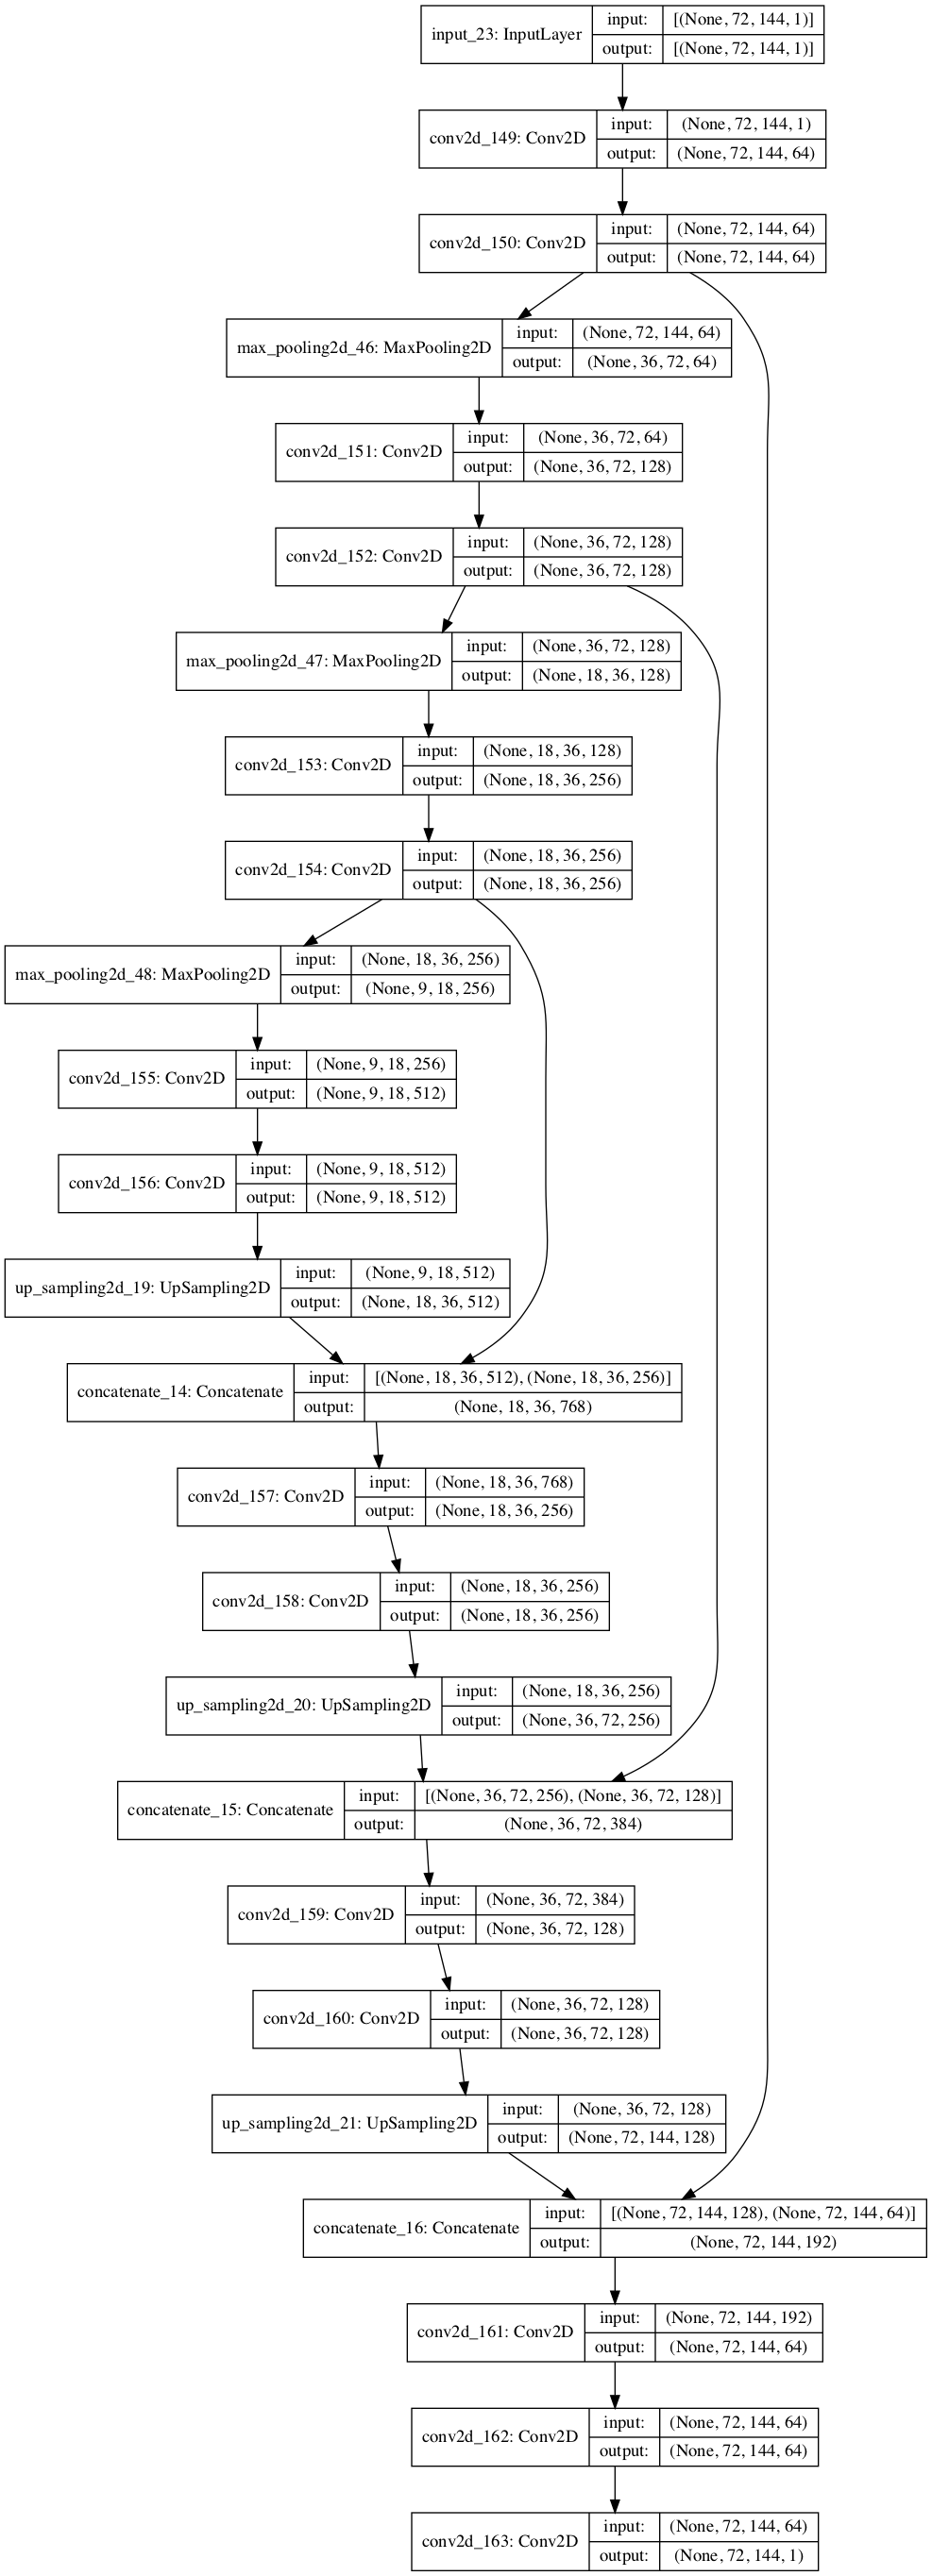

In [136]:
plot_model(model_UNet, show_shapes=True, show_layer_names=True)

### Train U-Net

In [26]:
## Get model predictions on train and validation data: FROM UNTRAINED MODEL!
train_pred_UNet = model_UNet.predict(train_input)
val_pred_UNet = model_UNet.predict(val_input)

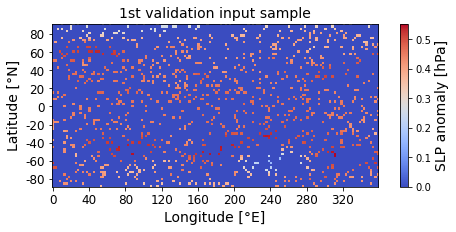

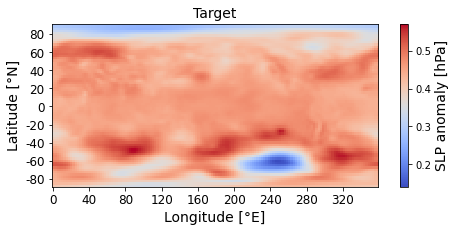

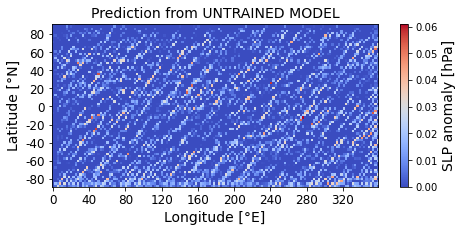

In [28]:
## Get model predictions on train and validation data: FROM UNTRAINED MODEL!
train_pred_UNet = model_UNet.predict(train_input)
val_pred_UNet = model_UNet.predict(val_input)

## Plot first input sample from validation data:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_input[0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('1st validation input sample', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding target:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_target[0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Target', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding model prediction:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_pred_UNet[0,:,:,0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Prediction from UNTRAINED MODEL', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

In [29]:
## Train model on randomly sparsified inputs with complete 2D fields as targets:
history = model_UNet.fit(train_input, train_target, epochs=1, verbose=1, shuffle=True,
                    batch_size=batch_size, validation_data=(val_input, val_target))

709/709 [==============================] - 33s 46ms/step - loss: 0.0328 - val_loss: 0.0018


In [30]:
## Get model predictions on train and validation data: FROM TRAINED MODEL after 1 epoch!
train_pred_UNet = model_UNet.predict(train_input)
val_pred_UNet = model_UNet.predict(val_input)

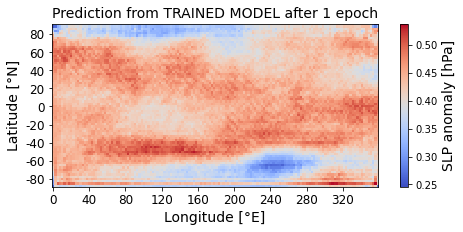

In [33]:
## Plot corresponding model prediction:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_pred_UNet[0,:,:,0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Prediction from TRAINED MODEL after 1 epoch', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

In [34]:
## Train model on randomly sparsified inputs with complete 2D fields as targets:
history = model_UNet.fit(train_input, train_target, epochs=1, verbose=1, shuffle=True,
                    batch_size=batch_size, validation_data=(val_input, val_target))

709/709 [==============================] - 33s 46ms/step - loss: 0.0015 - val_loss: 0.0012


In [35]:
## Get model predictions on train and validation data: FROM TRAINED MODEL after 2 epochs!
train_pred_UNet = model_UNet.predict(train_input)
val_pred_UNet = model_UNet.predict(val_input)

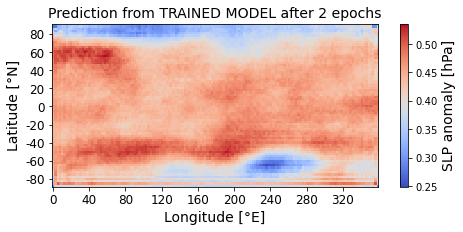

In [36]:
## Plot corresponding model prediction:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_pred_UNet[0,:,:,0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Prediction from TRAINED MODEL after 2 epochs', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

In [ ]:
## Now try large filter set, corresponding to [Xintao et al.]:

In [38]:
## Train model on randomly sparsified inputs with complete 2D fields as targets:
history = model_UNet.fit(train_input, train_target, epochs=1, verbose=1, shuffle=True,
                    batch_size=batch_size, validation_data=(val_input, val_target))

709/709 [==============================] - 1014s 1s/step - loss: 0.1392 - val_loss: 4.0768e-04


In [39]:
## Get model predictions on train and validation data: FROM TRAINED MODEL after 1 epoch!
train_pred_UNet = model_UNet.predict(train_input)
val_pred_UNet = model_UNet.predict(val_input)

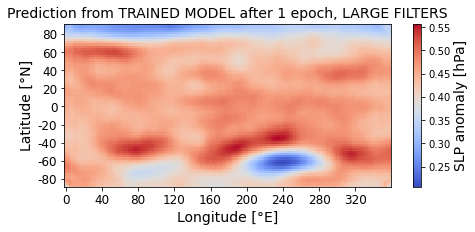

In [40]:
## Plot corresponding model prediction:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_pred_UNet[0,:,:,0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Prediction from TRAINED MODEL after 1 epoch, LARGE FILTERS', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

In [ ]:
## Next:
# Train model with original filter sizes, as in [Xintao et al.].
# Visualize learned CNN features --> nice xAI insight!
# Track loss / accuracy over increasing sparsity.
# Need some uncertainty measure!
# Find solution for upsampling, in case of un-even dimensions.
# Play with scaling / normalization in pre-processing.
# Find alternative for data augmentation: So far, just concatenate whole set of samples multiple times. Might not be the best choice.